<a href="https://colab.research.google.com/github/yujeonghyeop/Bitcoin-Anomaly-Transaction-Detection/blob/main/autoencoder_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#드라이브 마운트
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !pip install pycaret==2.3.10 markupsafe==2.0.1 pyyaml==5.4.1 -qq

In [ ]:
# 코랩에서 돌릴 때
# from pycaret.utils import enable_colab
# enable_colab() 

In [ ]:
from pycaret.classification import * # 순서대로 실행하다가 여기서 오류나면 위에 메뉴에서 '런타임'>'런타임 다시시작' 누른 다음 이거 실행 ㄱ ㄱ
from pycaret.utils import check_metric
from sklearn.model_selection import train_test_split

In [ ]:
#import library 정의
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, auc, precision_score
from sklearn.manifold import TSNE
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve, roc_auc_score, fbeta_score, recall_score
from sklearn.metrics import plot_precision_recall_curve, average_precision_score, f1_score, fbeta_score
from sklearn.metrics import plot_roc_curve
from sklearn import metrics
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.decomposition import PCA

%matplotlib inline
sns.set(style="whitegrid")
np.random.seed(203)


오토 머신러닝 함수 

평가 함수(이상치 스코어 함수) 및 그래프 함수 정의

In [ ]:
def anomalyScores(originalDF, reducedDF):
    loss = (np.array(originalDF) - np.array(reducedDF))**2
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    #print(loss)
    return loss

In [ ]:
def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    print(preds)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'], preds['anomalyScore'])

    average_precision = average_precision_score(preds['trueLabel'], preds['anomalyScore'])
    
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: Area under the \
        curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return preds, average_precision

In [ ]:
# 5/8 추가 평가함수

def get_clf_eval(y_test, y_pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    F2 = fbeta_score(y_test, y_pred, beta=2.0) # beta가 1보다 크면 recall에 비중
    F0_5 = fbeta_score(y_test, y_pred, beta=0.5) # beta가 1보다 작으면 precision에 비중
    AUC = roc_auc_score(y_test, y_pred)

    print('Confusion Matrix : \n', confusion)
    print('\nAccuracy: {:.4f}'.format(accuracy))
    print('Precision: {:.4f}'.format(precision))
    print('Recall: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('F2: {:.4f}'.format(F2))
    print('F0.5: {:.4f}'.format(F0_5))
    print('AUC: {:.4f}'.format(AUC))

    confusion_matrix_plot(confusion)

In [ ]:
# 5/8 추가 confusion matrix plot

def confusion_matrix_plot(cm):
    class_names = [0,1]
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)

    sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu", fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y = 1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

특정 재현율 임계점별 정밀도를 평가하기 위한 새로운 함수 정의

In [ ]:
def precisionAnalysis(df, column, threshold):
    df.sort_values(by=column, ascending=False, inplace=True)
    threshold_value = threshold*df.trueLabel.sum()
    i = 0
    j = 0
    while i < threshold_value+1:
        if df.iloc[j]["trueLabel"]==1:
            i += 1
        j += 1
    return df, i/j

In [ ]:
# 산점도 그래프 함수
def scatterPlot(xDF, yDF, algoName):
    tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
    tempDF = pd.concat((tempDF, yDF), axis =1, join="inner")
    tempDF.columns = ["First Vector", "Second Vector", "Label"]
    sns.lmplot(x="First Vector", y="Second Vector", hue="Label", data=tempDF, fit_reg=False)
    ax = plt.gca()
    ax.set_title("Separation of Observations using " + algoName)



pandas로 데이터셋 읽어오기

In [ ]:
# raw_features = pd.read_csv("/content/drive/Shareddrives/bigdata_2022-1/elliptic_txs_features.csv")
# raw_classes = pd.read_csv("/content/drive/Shareddrives/bigdata_2022-1/elliptic_txs_classes.csv")
# raw_edgelist = pd.read_csv("/content/drive/Shareddrives/bigdata_2022-1/elliptic_txs_edgelist.csv")

raw_features = pd.read_csv("../elliptic_txs_features.csv")
raw_classes = pd.read_csv("../elliptic_txs_classes.csv")
raw_edgelist = pd.read_csv("../elliptic_txs_edgelist.csv")

In [ ]:
# renaming columns
raw_features.columns = ['id', 'time'] + [f'trans_feat_{i}' for i in range(93)] + [f'agg_feat_{i}' for i in range(72)]
raw_features.head()

,id,time,trans_feat_0,trans_feat_1,trans_feat_2,trans_feat_3,trans_feat_4,trans_feat_5,trans_feat_6,trans_feat_7,trans_feat_8,trans_feat_9,trans_feat_10,trans_feat_11,trans_feat_12,trans_feat_13,trans_feat_14,trans_feat_15,trans_feat_16,trans_feat_17,trans_feat_18,trans_feat_19,trans_feat_20,trans_feat_21,trans_feat_22,trans_feat_23,trans_feat_24,trans_feat_25,trans_feat_26,trans_feat_27,trans_feat_28,trans_feat_29,trans_feat_30,trans_feat_31,trans_feat_32,trans_feat_33,trans_feat_34,trans_feat_35,trans_feat_36,trans_feat_37,trans_feat_38,trans_feat_39,trans_feat_40,trans_feat_41,trans_feat_42,trans_feat_43,trans_feat_44,trans_feat_45,trans_feat_46,trans_feat_47,trans_feat_48,trans_feat_49,trans_feat_50,trans_feat_51,trans_feat_52,trans_feat_53,trans_feat_54,trans_feat_55,trans_feat_56,trans_feat_57,trans_feat_58,trans_feat_59,trans_feat_60,trans_feat_61,trans_feat_62,trans_feat_63,trans_feat_64,trans_feat_65,trans_feat_66,trans_feat_67,trans_feat_68,trans_feat_69,trans_feat_70,trans_feat_71,trans_feat_72,trans_feat_73,trans_feat_74,trans_feat_75,trans_feat_76,trans_feat_77,trans_feat_78,trans_feat_79,trans_feat_80,trans_feat_81,trans_feat_82,trans_feat_83,trans_feat_84,trans_feat_85,trans_feat_86,trans_feat_87,trans_feat_88,trans_feat_89,trans_feat_90,trans_feat_91,trans_feat_92,agg_feat_0,agg_feat_1,agg_feat_2,agg_feat_3,agg_feat_4,agg_feat_5,agg_feat_6,agg_feat_7,agg_feat_8,agg_feat_9,agg_feat_10,agg_feat_11,agg_feat_12,agg_feat_13,agg_feat_14,agg_feat_15,agg_feat_16,agg_feat_17,agg_feat_18,agg_feat_19,agg_feat_20,agg_feat_21,agg_feat_22,agg_feat_23,agg_feat_24,agg_feat_25,agg_feat_26,agg_feat_27,agg_feat_28,agg_feat_29,agg_feat_30,agg_feat_31,agg_feat_32,agg_feat_33,agg_feat_34,agg_feat_35,agg_feat_36,agg_feat_37,agg_feat_38,agg_feat_39,agg_feat_40,agg_feat_41,agg_feat_42,agg_feat_43,agg_feat_44,agg_feat_45,agg_feat_46,agg_feat_47,agg_feat_48,agg_feat_49,agg_feat_50,agg_feat_51,agg_feat_52,agg_feat_53,agg_feat_54,agg_feat_55,agg_feat_56,agg_feat_57,agg_feat_58,agg_feat_59,agg_feat_60,agg_feat_61,agg_feat_62,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71
0,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,-0.167948,-0.049707,-0.164417,-0.028741,-0.035391,-0.042955,-0.013282,-0.055327,-0.169757,-0.171477,-0.174490,0.887058,0.884557,-0.139731,-0.148912,-0.080147,-0.155661,-0.010763,-0.012107,-0.139733,-0.148907,-0.080147,-0.155661,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,0.001483,-0.227215,-0.239368,-0.075256,-0.234952,0.037468,0.043444,-0.227203,-0.243236,-0.097895,-0.235896,0.036577,0.042345,-0.413965,-0.488307,-0.232553,-0.467516,0.048767,0.052956,-0.039151,-0.172895,-0.163126,-0.160933,0.923473,0.923011,-0.039146,-0.172884,-0.163114,-0.160926,0.923516,0.923110,-0.017032,-0.030026,-0.017640,-0.015071,-0.140763,-0.140335,-0.095403,-0.264425,-0.250574,-0.263753,-0.169119,-0.167165,-0.059013,-0.262424,-0.255168,-0.259251,-0.187191,-0.185274,-0.293692,-0.760700,-0.692777,-0.719789,-1.084907,-1.084845,-0.170113,-0.202332,-0.116817,-0.192405,-0.014659,-0.018849,-1.457921,-1.494024,-0.083459,-1.485939,-0.088798,-0.090437,-0.166550,-0.216536,-0.134546,-0.194817,-0.003175,-0.004094,-1.096336,-1.267340,-0.349933,-1.230441,-0.004358,-0.004194,-0.116425,-0.176617,-0.137323,-0.152464,-0.026060,-0.027660,-0.093145,-0.143707,-0.097719,-0.127462,0.003143,0.002426,-0.121330,-0.110933,-0.075909,-0.111641,-1.159649,-1.160129,-1.373723,-1.353918,-0.295982,-1.403215,-0.975738,-0.975237,-0.168742,-0.263290,-0.186389,-0.250875,-1.015963,-1.016230,-0.968903,0.146997,1.366287,-0.464773,-1.116918,-1.116948,-0.216814,0.634272,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,-0.168576,-0.049707,-0.165054,-0.028741,-0.035391,-0.042955,-0.013282,-0.055298,-0.170400,-0.172217,-0.175227,0

In [ ]:
# merge with classes

raw_features = pd.merge(raw_features, raw_classes, left_on='id', right_on='txId', how='left')

preprocessing

In [ ]:
#PCA 데이터 전처리 함수
def preprocessing(raw_data):

  raw_data.pop('time')
  raw_data.pop('txId')
  raw_data.pop("id")

  unknown_index = raw_data[raw_data['class'] == 'unknown'].index
  data_clean = raw_data.drop(unknown_index)

  data_clean['class'].replace({"1" : "1"}, inplace=True)
  data_clean['class'].replace({"2" : "0"}, inplace=True)
  data_clean['class'] = data_clean['class'].astype(float)

#상관관계 분석으로 Threshold(3%) 미만인 경우 삭제
  corr = data_clean.corr()
  corr_sort = abs(data_clean.corr()['class']).sort_values()
  corr_sort = corr_sort[corr_sort < 0.03]
  pdpd = pd.DataFrame(corr_sort)
  deletearray = pdpd.index
  for i in deletearray:
    data_clean.pop(i)
  

  #Class Feature을 제외한 나머지 Feature들 정규화 작업
  # std_data = preprocessing.StandardScaler().fit_transform(data.iloc[:, :-1])
  # std_data = pd.DataFrame(std_data, index = data.index, columns = data.columns[:-1])

  #Trans feature 따로 저장
  std_data_1 = data_clean.iloc[:,[k for k in range(60)]]

  #Agg Feature 따로 저장
  std_data_2 = data_clean.iloc[:,[k for k in range(60,103)]]

  #Trans Feature PCA 결과에 따라 20개의 주성분으로 압축
  pca_1 = PCA(n_components= 20)
  pca_1_array = pca_1.fit_transform(std_data_1)
  pca_1_df = pd.DataFrame(pca_1_array, index = std_data_1.index, columns = [f"pca{num+1}" for num in range(0,20)])

  #Agg Feature PCA 결과에 따라 25개의 주성분으로 압축
  pca_2 = PCA(n_components= 25)
  pca_2_array = pca_2.fit_transform(std_data_2)
  pca_2_df = pd.DataFrame(pca_2_array, index = std_data_2.index, columns = [f"pca{num+1}" for num in range(20,45)])

  #압축한 Trans Feature와 Agg Feature 합침
  realdata = pd.concat([pca_1_df,pca_2_df],axis=1)

  #위에서 합친 데이터에 Class Feature도 추가해줌.
  labeldata = pd.concat([realdata,data_clean['class']],axis=1)
  return labeldata


In [ ]:
def autoencoder(raw_data):
  
  # 불필요한 컬럼 제거
  raw_data.pop('time')
  raw_data.pop('txId')
  raw_data.pop("id")

  # unknown label 제거
  unknown_index = raw_data[raw_data['class'] == 'unknown'].index
  data_clean = raw_data.drop(unknown_index)

  adata = data_clean.copy()
  X = adata.drop(['class'], axis = 1).values
  Y = adata['class'].values

  input_layer = Input(shape=(X.shape[1],))

  encoded = Dense(100, activation='tanh', activity_regularizer = regularizers.l1(10e-5))(input_layer)
  encoded = Dense(45, activation='relu')(encoded)

  decoded = Dense(50, activation='tanh')(encoded)
  decoded = Dense(100, activation='tanh')(decoded)

  output_layer = Dense(X.shape[1], activation='relu')(decoded)
  # output_layer = Dense(X.shape[1], activation='relu')(encoded)

  autoencoder = Model(input_layer, output_layer)

  autoencoder.compile(optimizer="adadelta", loss="mse")
  x = adata.drop(["class"], axis = 1) 
  y = adata["class"].values

  x_scale = x.values
  x_normal = x_scale[y == '2']
  x_fraud = x_scale[y == '1']
  autoencoder.fit(x_normal, x_normal,batch_size = 256, epochs = 1,shuffle = True, validation_split = 0.20);

  hidden_representation = Sequential()
  hidden_representation.add(autoencoder.layers[0])
  hidden_representation.add(autoencoder.layers[1])
  hidden_representation.add(autoencoder.layers[2])

  norm_hid_rep = hidden_representation.predict(x_normal)
  fraud_hid_rep = hidden_representation.predict(x_fraud)
  rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)

  y_n = np.zeros(norm_hid_rep.shape[0]) 
  y_f = np.ones(fraud_hid_rep.shape[0])
  rep_y = np.append(y_n, y_f)

  return rep_x, rep_y

In [ ]:
raw_data = raw_features.copy()

rep_X, rep_y = autoencoder(raw_data)
rep_data = pd.DataFrame(rep_X)
rep_y = pd.DataFrame(rep_y)
rep_data['class'] = rep_y

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-06-14 14:54:00.796594: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-14 14:54:00.797464: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-06-14 14:54:01.062687: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-14 14:54:01.252267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


132/132 [==============================] - 2s 10ms/step - loss: 2.3881 - val_loss: 1.9001


2022-06-14 14:54:02.670674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-14 14:54:02.869141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


AutoML

In [ ]:
# setup으로 init
# clf = setup(data = pca_data, train_size = 0.7, normalize=True, target = 'class', silent = True, fold=5, session_id=13)
clf = setup(data = rep_data, train_size = 0.7, normalize=True, target = 'class', silent = True, fold=5, session_id=13)

,Description,Value
0,session_id,13
1,Target,class
2,Target Type,Binary
3,Label Encoded,"0.0: 0, 1.0: 1"
4,Original Data,"(46564, 46)"
5,Missing Values,False
6,Numeric Features,45
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [ ]:
# ML 모델 성능 비교
top3 = compare_models(sort = 'f1', n_select = 3, fold = 5, exclude = ['knn', 'et', 'xgboost']) #모델 선정하기

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9689,0.9641,0.7431,0.9225,0.8231,0.8062,0.8119,0.4680
rf,Random Forest Classifier,0.9694,0.9645,0.7150,0.9610,0.8198,0.8035,0.8141,0.9600
gbc,Gradient Boosting Classifier,0.9603,0.9427,0.6687,0.8969,0.7660,0.7448,0.7545,7.0040
dt,Decision Tree Classifier,0.9404,0.8458,0.7283,0.6815,0.7041,0.6710,0.6715,0.4520
lr,Logistic Regression,0.9491,0.9173,0.6062,0.8252,0.6988,0.6718,0.6814,0.6380
svm,SVM - Linear Kernel,0.9472,0.0000,0.6003,0.8100,0.6882,0.6601,0.6697,0.0860
lda,Linear Discriminant Analysis,0.9473,0.8927,0.5962,0.8131,0.6877,0.6597,0.6693,0.0880
ada,Ada Boost Classifier,0.9455,0.9264,0.6018,0.7891,0.6827,0.6535,0.6608,1.2280
qda,Quadratic Discriminant Analysis,0.8811,0.9384,0.8458,0.4421,0.5807,0.5192,0.5564,0.0580
nb,Naive Bayes,0.7625,0.8870,0.7828,0.2604,0.3908,0.2866,0.3538,0.2280


In [ ]:
lgbm = create_model('lightgbm')
lgbm

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9686,0.9638,0.7429,0.9181,0.8213,0.8042,0.8097
1,0.9693,0.9659,0.7445,0.9255,0.8252,0.8086,0.8143
2,0.9670,0.9612,0.7402,0.9038,0.8139,0.7960,0.8007
3,0.9659,0.9604,0.7150,0.9172,0.8035,0.7852,0.7925
4,0.9738,0.9692,0.7729,0.9478,0.8514,0.8372,0.8425
Mean,0.9689,0.9641,0.7431,0.9225,0.8231,0.8062,0.8119
Std,0.0027,0.0032,0.0184,0.0144,0.0160,0.0174,0.0170


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=13, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
rf = create_model('rf')
rf

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9689,0.9601,0.7224,0.9443,0.8186,0.8019,0.8105
1,0.9689,0.9682,0.7082,0.9615,0.8156,0.7990,0.8102
2,0.9698,0.9619,0.7150,0.9660,0.8217,0.8056,0.8165
3,0.9663,0.9650,0.6835,0.9581,0.7978,0.7799,0.7932
4,0.9735,0.9672,0.7461,0.9753,0.8454,0.8312,0.8401
Mean,0.9694,0.9645,0.7150,0.9610,0.8198,0.8035,0.8141
Std,0.0023,0.0031,0.0203,0.0101,0.0152,0.0164,0.0151


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=13, verbose=0,
                       warm_start=False)

In [ ]:
svm = create_model('svm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9419,0.0000,0.6262,0.7365,0.6769,0.6452,0.6478
1,0.9515,0.0000,0.6325,0.8285,0.7174,0.6914,0.6989
2,0.9420,0.0000,0.5260,0.8127,0.6386,0.6087,0.6257
3,0.9497,0.0000,0.6189,0.8205,0.7056,0.6786,0.6867
4,0.9508,0.0000,0.5978,0.8517,0.7025,0.6766,0.6892
Mean,0.9472,0.0000,0.6003,0.8100,0.6882,0.6601,0.6697
Std,0.0043,0.0000,0.0389,0.0390,0.0281,0.0299,0.0281


모델 생성 끝

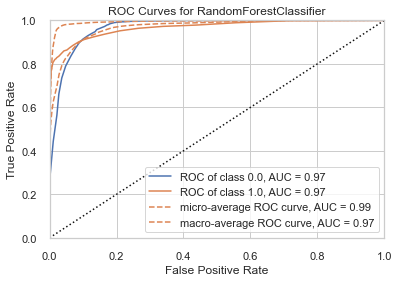

In [ ]:
plot_model(rf, 'auc')
# plot_model(lr, 'auc')

# plot_model(lgbm, 'auc')

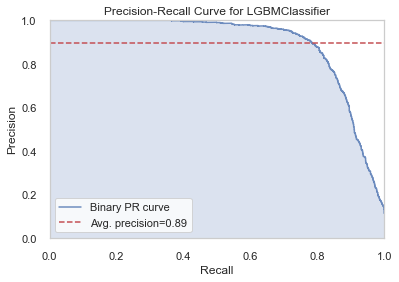

In [ ]:
plot_model(lgbm, 'pr')

In [ ]:
tuned_rf = tune_model(rf, fold=5, optimize='f1')


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9455,0.9518,0.8233,0.6824,0.7462,0.7160,0.7200
1,0.9489,0.9518,0.8218,0.7031,0.7578,0.7295,0.7322
2,0.9406,0.9516,0.7953,0.6627,0.7230,0.6900,0.6936
3,0.9448,0.9465,0.8016,0.6851,0.7388,0.7081,0.7108
4,0.9503,0.9578,0.8407,0.7050,0.7669,0.7393,0.7429
Mean,0.9460,0.9519,0.8165,0.6877,0.7465,0.7166,0.7199
Std,0.0034,0.0036,0.0163,0.0155,0.0152,0.0171,0.0171


In [ ]:
tuned_rf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=8, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0005, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=9,
                       min_weight_fraction_leaf=0.0, n_estimators=170,
                       n_jobs=-1, oob_score=False, random_state=13, verbose=0,
                       warm_start=False)

In [ ]:
tuned_lgbm = tune_model(lgbm, fold=5, optimize='f1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9702,0.9658,0.7524,0.9280,0.8310,0.8149,0.8203
1,0.9705,0.9670,0.7413,0.9438,0.8304,0.8145,0.8216
2,0.9682,0.9667,0.7339,0.9246,0.8183,0.8011,0.8075
3,0.9676,0.9644,0.7244,0.9274,0.8134,0.7960,0.8033
4,0.9736,0.9712,0.7697,0.9494,0.8502,0.8359,0.8414
Mean,0.9701,0.9670,0.7443,0.9346,0.8287,0.8125,0.8188
Std,0.0021,0.0023,0.0156,0.0100,0.0127,0.0138,0.0133


In [ ]:
tuned_lgbm

LGBMClassifier(bagging_fraction=0.8, bagging_freq=4, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.4,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=76, min_child_weight=0.001, min_split_gain=0.5,
               n_estimators=80, n_jobs=-1, num_leaves=90, objective=None,
               random_state=13, reg_alpha=0.4, reg_lambda=1e-06, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
# 튜닝한 모델 블렌딩
blended_model = blend_models(estimator_list = [tuned_lgbm, tuned_rf], fold = 5, method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9687,0.9590,0.7776,0.8867,0.8286,0.8114,0.8136
1,0.9684,0.9583,0.7634,0.8963,0.8245,0.8073,0.8104
2,0.9664,0.9589,0.7591,0.8796,0.8149,0.7965,0.7991
3,0.9655,0.9541,0.7402,0.8868,0.8069,0.7881,0.7920
4,0.9727,0.9640,0.7934,0.9145,0.8497,0.8347,0.8373
Mean,0.9683,0.9589,0.7667,0.8928,0.8249,0.8076,0.8105
Std,0.0025,0.0031,0.0179,0.0121,0.0145,0.0158,0.0155


In [ ]:
blended_model

VotingClassifier(estimators=[('lightgbm',
                              LGBMClassifier(bagging_fraction=0.8,
                                             bagging_freq=4,
                                             boosting_type='gbdt',
                                             class_weight=None,
                                             colsample_bytree=1.0,
                                             feature_fraction=0.4,
                                             importance_type='split',
                                             learning_rate=0.1, max_depth=-1,
                                             min_child_samples=76,
                                             min_child_weight=0.001,
                                             min_split_gain=0.5,
                                             n_estimators=80, n_jobs=-1,
                                             num_leaves=90, objective=None,
                                             rand...
              

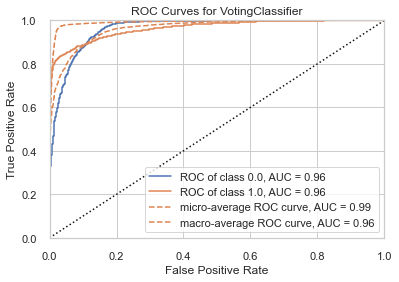

In [ ]:
plot_model(blended_model, 'auc')

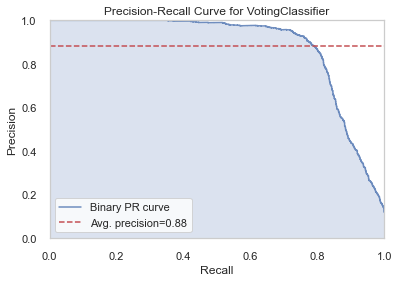

In [ ]:
plot_model(blended_model, 'pr')

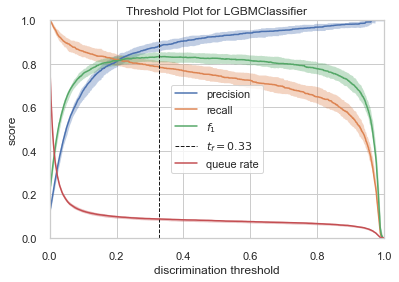

In [ ]:
plot_model(lgbm, 'threshold')

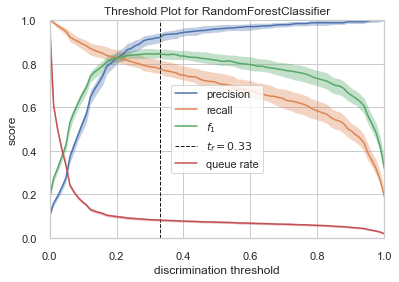

In [ ]:
plot_model(rf, 'threshold')

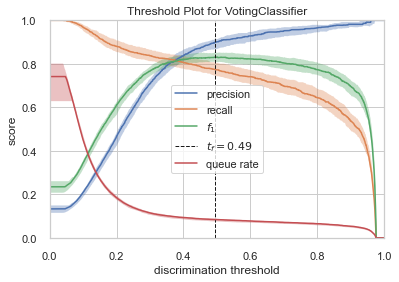

In [ ]:
plot_model(blended_model, 'threshold')

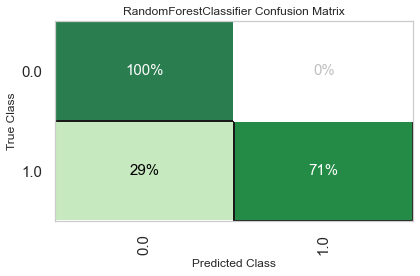

In [ ]:
plot_model(rf, 'confusion_matrix', plot_kwargs = {'percent' : True})

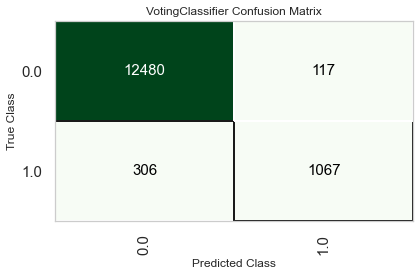

In [ ]:
# 오차 행렬
plot_model(blended_model, 'confusion_matrix', plot_kwargs = {'percent' : True})
plot_model(blended_model, 'confusion_matrix')

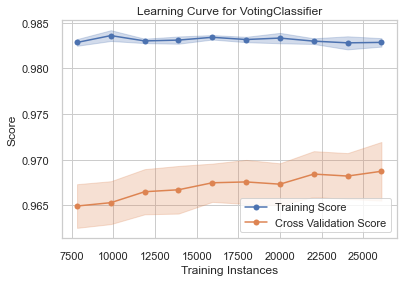

In [ ]:
plot_model(blended_model, 'learning')